# Introduction
Neural networks have become a powerful tool for automating complex tasks in crystallography, especially as applied to PXRD data. For example, [indexing](https://scripts.iucr.org/cgi-bin/paper?vb5020), [crystallite size and scale factor](https://www.nature.com/articles/s41524-021-00542-4) determination, as well as [crystal system and space group](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.245120) [classification](https://journals.iucr.org/m/issues/2017/04/00/fc5018/index.html). There are many more examples in the literature! Modern approaches typically make use of architectures built from convolutional layers, which are well suited to 1D PXRD data.

In this post, we'll look at using neural networks to automatically remove both the amorphous scattering background and experimental noise from PXRD data. Subtracting backgrounds (or at least effectively modelling them) is required for SDPD (for example using GALLOP) to proceed  - this is because extracting accurate intensities for the scattering phase of interest from the diffraction data is critical. Traditionally, background removal is done manually by fitting smooth functions to estimate the background - this process is subjective; it takes experience and expertise to understand and determine when the fit to the background is "good enough". We're going to look at using neural networks to automate this process.

The [UNet](https://arxiv.org/abs/1505.04597) architecture is well-suited for image-to-image tasks, and was originally designed for segmenting biomedical images.

![](./images/UNet.png)

The UNet design has several advantages:
- Encoder-decoder structure: The encoder gradually compresses the input image into a smaller latent representation, while the decoder gradually reconstructs the image from this representation. This allows the model to learn robust features for denoising in the encoder, while preserving high resolution details in the decoder.
- Skip connections: UNet has skip connections that concatenate encoder and decoder features at each stage. This allows low-level features to be propagated across the model, preserving fine details and improving pixel-level prediction.
- Convolutional layers: UNet uses convolutional layers which are ideal for learning spatially-localised features in images. Convolutions help the model learn effective filters for removing background noise.
- End-to-end learning: UNet can be trained end-to-end directly on noisy and clean PXRD image pairs. This allows the model to learn the optimal filters for denoising the specific data, without manual feature engineering.
- Fast inference: Once trained, UNet can denoise images quickly in a feedforward pass. This allows near real-time processing of large PXRD datasets.

Overall, the UNet architecture provides an excellent balance of contextual feature learning while preserving detailed pixel-level information critical for image denoising tasks. In this blog post, I will discuss how UNet can be adapted for use with PXRD data, and trained on noisy and clean PXRD patterns to automate background subtraction.

# Modifying UNet for PXRD data

While UNet was originally designed for 2D image inputs, we can adapt it for 1D PXRD data by modifying the convolutional layers. Specifically, we replace the 2D convolutional layers with 1D equivalents. I also opted to replace the individual convolutional layers in the original UNet with 1D versions of [ConvNeXt V2 blocks](https://arxiv.org/abs/2301.00808), which have been used to significantly improve the performance of convolutional neural networks on image classification, object detection and image segmentation tasks.

![](./images/ConvNeXtV2_block.png)

In this work, the ConvNeXt V2 block is modified to use 1D convolutions. Like the original ConvNeXt V2 block, the middle dimension expansion layer has 4 x the number of channels compared to the input layer. The output layer may have more channels than the input later. Where this is the case, the skip connection shown is modified to use a 1D convolution with kernel size 1 to project the input to the appropriate number of dimensions before addition. Using these modified blocks, I ended up with the following architecture:

![](./images/Unet.drawio.png)

In total, the neural network has approximately 1 million parameters. This relatively low number of parameters is due to the parameter-efficient ConvNeXt V2 blocks, and the relatively simple task that it has been applied to. I've provided the pytorch code for the neural network below.

In [1]:
#| code-fold: true
import torch
from torch import nn

class GRN(nn.Module):
    # global response normalization, proposed in updated convnext paper
    # Code adapted from https://github.com/lucidrains/x-unet/blob/main/x_unet/x_unet.py
    # Modified to work with 1D data
    def __init__(self, dim, eps = 1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.zeros(1, dim, 1))
        self.bias = nn.Parameter(torch.zeros(1, dim, 1))

    def forward(self, x):
        # Input is Batch,Channels,Length
        # Want to average first over length, then divide by average channel
        spatial_l2_norm = x.norm(p = 2, dim = (2), keepdim = True)
        feat_norm = spatial_l2_norm / spatial_l2_norm.mean(dim = 1, keepdim = True).clamp(min = self.eps)
        val = x * feat_norm * self.gamma + self.bias + x
        return val

class conv_block(nn.Module):
    def __init__(self, in_c, out_c, dim):
        super().__init__()
        self.depth_1 = nn.Conv1d(in_channels=in_c, out_channels=in_c, kernel_size=7, groups=in_c, padding=3)
        self.point_1 = nn.Conv1d(in_channels=in_c, out_channels=in_c, kernel_size=1, padding=0)
        self.conv1_1 = nn.Conv1d(in_c, 4*in_c, kernel_size=1, padding=0)
        self.conv2_1 = nn.Conv1d(4*in_c, in_c, kernel_size=1, padding=0)
        self.ln_1 = nn.LayerNorm((in_c,dim))
        self.GRN_1 = GRN(4*in_c)
        self.gelu = nn.GELU()
        if in_c != out_c:
            self.shortcut = nn.Conv1d(in_c, out_c, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, inputs):
        x = self.depth_1(inputs)
        x = self.point_1(x)
        x = self.ln_1(x)
        x = self.conv1_1(x)
        x = self.gelu(x)
        x = self.GRN_1(x)
        x = self.conv1_2(x)
        x = x + self.shortcut(inputs)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c, dim):
        super().__init__()
        self.conv = conv_block(in_c, out_c, dim)
        self.down = nn.Conv1d(out_c, out_c, kernel_size=2, stride=2, padding=0)

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.down(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, dim):
        super().__init__()
        self.up = nn.ConvTranspose1d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c, dim)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self, channels, dim):
        super().__init__()
        self.inputs = conv_block(1, channels, dim)

        # Encoder
        self.e1 = encoder_block(channels, channels, dim)
        self.e2 = encoder_block(channels, channels*2, dim//2)
        self.e3 = encoder_block(channels*2, channels*4, dim//4)
        self.e4 = encoder_block(channels*4, channels*8, dim//8)
        # Middle
        self.b = conv_block(channels*8, channels*16, dim//16)
        # Decoder
        self.d1 = decoder_block(channels*16, channels*8, dim//8)
        self.d2 = decoder_block(channels*8, channels*4, dim//4)
        self.d3 = decoder_block(channels*4, channels*2, dim//2)
        self.d4 = decoder_block(channels*2, channels, dim)
        # Output
        self.output_1 = conv_block(channels, channels, dim)
        self.output_2 = conv_block(channels, channels, dim)
        self.output_3 = nn.Conv1d(channels, 1, kernel_size=7, padding=3)

    def forward(self, src):
        inputs = self.inputs(src)

        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Middle
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        # Output
        output = self.output_1(d4)
        output = self.output_2(output)
        output = self.output_3(output)

        return output

# Training data
## Diffraction data
I used the [PowCod database](https://www.researchgate.net/publication/273507012_QUALX20_A_qualitative_phase_analysis_software_using_the_freely_available_database_POW-COD) produced by the [Bari group](https://www.ba.ic.cnr.it/softwareic/qualx/powcod-download/) as the source for the training data. This database contains diffraction data for a large number of crystal structures obtained from the [crystallography open database](http://www.crystallography.net/cod/), and made this project much easier than it otherwise would be. PowCod provides lots of information, most pertinent for this work is the unit cells, space groups, Miller indices and associated intensities for all of the crystal structures. I applied some filtering to this, and ended up with a dataset comprising 258k diffraction patterns.

I wrote some PyTorch-based code to generate relatively realistic looking PXRD data on-the-fly using my GPU. I've included several methods of data augmentation:

- Modification of unit cells to simulate thermal expansion / contraction
- Modification of noise to simulate different experimental data collection times / sample sizes
- Modification of peak shapes, broadening and asymmetry to simulate different crystallite sizes and strains and instrumentation (full Voigt peaks are calculated with axial divergence using the method published by [Finger et al.](https://scripts.iucr.org/cgi-bin/paper?hn0025))
- Modification of zero point errors to simulate different instruments
- Modification of intensities using the March-Dollase method to simulate preferred orientation effects

In the next sections, we'll see how I filtered the original dataset, and then go over the code used to generate the relatively realistic looking diffraction data.


## Filtering PowCod data
The PowCod dataset, which can be obtained here, is made up of several .sql files which need to be parsed to extract the desired information. In our case, what we are after is:
- Unit cells
- Crystal systems
- Miller indices
- Intensities

We'll probably also need to use some additional information to help us along the way, for example, the d-spacing of the reflections.

As the files total only around 5.5 GB, I used pandas to read the database into memory and extract the information needed. I pickled the resultant dataframe to enable it to be more easily read in the future.

In [2]:
import pandas as pd
import os


def read_powcod_sql():
    import sqlite3
    con = sqlite3.connect('cod2205.sq')
    df = pd.read_sql_query('SELECT * FROM id',con)
    con2 = sqlite3.connect('cod2205.sq.info')
    df2 = pd.read_sql_query('SELECT * FROM info',con2)

    df.id = pd.to_numeric(df.id)
    df2.id = pd.to_numeric(df2.id)

    combined = df.merge(df2, left_on="id", right_on="id")
    return combined

if os.path.isfile("combined.pkl"):
    combined = pd.read_pickle("combined.pkl")
else:
    combined = read_powcod_sql()
    print(combined.columns)
    combined = combined[["spacegroup_x", "a", "b", "c", "alpha", "beta",
                    "gamma", "volume", "h", "k", "l", "nd", "dvalue",
                    "intensita", "type"]]
    combined.to_pickle("combined.pkl")

Let's have a look at what we've got:

In [3]:
combined

,spacegroup_x,a,b,c,alpha,beta,gamma,volume,h,k,l,nd,dvalue,intensita,type
0,C m c m,0.0000,0.0000,0.0000,0.0,0.000,0.0,738.078,0,0,0,1,0.000000,0.000000,Orthorhombic
1,I 4/m m m,0.0000,0.0000,0.0000,0.0,0.000,0.0,388.473,0,0,0,1,0.000000,0.000000,Tetragonal
2,P -1,0.0000,0.0000,0.0000,0.0,0.000,0.0,429.928,0,0,0,1,0.000000,0.000000,Triclinic
3,P -3,0.0000,0.0000,0.0000,0.0,0.000,0.0,1221.297,0,0,0,1,0.000000,0.000000,Trigonal (hexagonal axes)
4,P 1,0.0000,0.0000,0.0000,0.0,0.000,0.0,552.983,0,0,0,1,0.000000,0.000000,Cubic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458155,P 1 21 1,6.6330,15.4171,11.9417,90.0,103.335,90.0,1188.257,"0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,0,1,1,1,1,1,...","0,1,2,0,2,0,1,1,0,1,0,2,0,1,2,3,1,2,2,2,3,3,0,...","1,1,0,0,1,-1,0,-1,2,2,1,0,-2,1,-1,1,-2,2,1,-2,...",499,"11.619700,9.279300,7.708500,6.454200,6.423600,...","1000.000000,62.638200,82.940500,3.929300,0.067...",Monoclinic
458156,C 1 2/m 1,21.2287,17.8117,12.3055,90.0,124.759,90.0,3822.662,"1,1,0,2,0,2,0,2,1,3,2,2,1,1,3,3,1,2,4,2,0,4,1,...","1,1,0,0,2,0,2,2,1,1,2,0,3,1,1,1,3,0,0,2,0,0,3,...","0,-1,1,-1,0,0,1,-1,1,-1,0,-2,0,-2,0,-2,-1,1,-1...",498,"12.461500,10.123800,10.109700,9.999700,8.90580...","1000.000000,1.459300,384.189200,186.432500,88....",Monoclinic
458157,C 1 2/m 1,21.5314,18.0366,12.3918,90.0,124.872,90.0,3948.216,"1,1,0,2,0,2,0,2,1,3,2,2,1,3,1,3,1,2,4,2,0,4,1,...","1,1,0,0,2,0,2,2,1,1,2,0,3,1,1,1,3,0,0,2,0,0,3,...","0,-1,1,-1,0,0,1,-1,1,-1,0,-2,0,0,-2,-2,-1,1,-1...",498,"12.620300,10.213500,10.166600,10.122700,9.0183...","1000.000000,0.425500,401.199700,131.443500,109...",Monoclinic
458158,I -4 2 m,10.2400,10.2400,9.6520,90.0,90.000,90.0,1012.086,"1,1,2,0,2,1,2,2,3,3,1,2,3,3,2,4,3,0,4,3,4,1,4,...","1,0,0,0,1,1,2,0,1,0,0,2,2,1,1,0,3,0,1,0,2,1,0,...","0,1,0,2,1,2,0,2,0,1,3,2,1,2,3,0,0,4,1,3,0,4,2,...",302,"7.240800,7.023700,5.120000,4.826000,4.137400,4...","435.793700,1000.000000,156.773800,74.174400,1....",Tetragonal


In [4]:
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd
count,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000
mean,12.505100,13.372528,16.330272,89.503372,95.199651,90.906179,3178.613746,454.593930
std,6.874009,6.655914,8.092967,8.326557,11.649541,10.924374,6384.755145,119.026662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.282900,9.153000,11.279975,90.000000,90.000000,90.000000,1089.974000,498.000000
50%,10.780000,12.130000,15.169000,90.000000,92.430000,90.000000,1976.458000,499.000000
75%,14.703000,16.140000,19.860000,90.000000,101.688000,90.000000,3562.973750,500.000000
max,189.800000,150.000000,475.977800,150.172000,173.895000,149.900000,740478.188000,500.000000


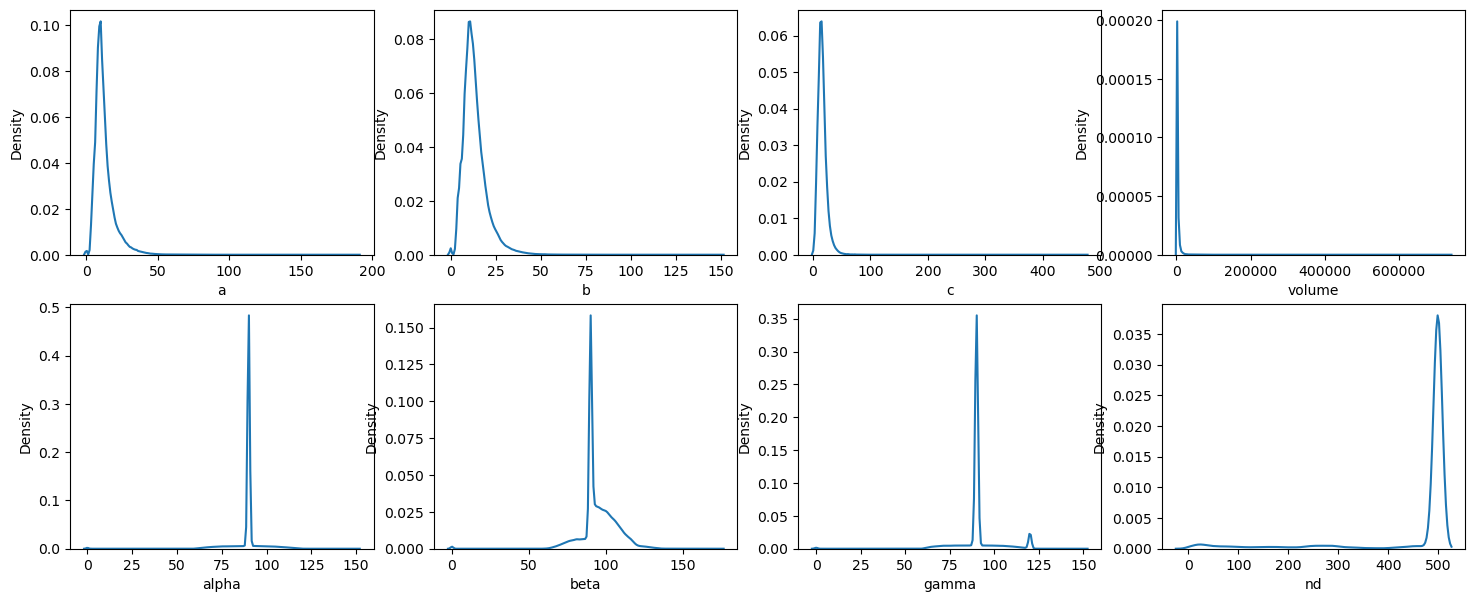

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(18,7))
sns.kdeplot(combined.a, ax=ax[0][0])
sns.kdeplot(combined.b, ax=ax[0][1])
sns.kdeplot(combined.c, ax=ax[0][2])
sns.kdeplot(combined.volume, ax=ax[0][3])
sns.kdeplot(combined.alpha, ax=ax[1][0])
sns.kdeplot(combined.beta, ax=ax[1][1])
sns.kdeplot(combined.gamma, ax=ax[1][2])
sns.kdeplot(combined.nd, ax=ax[1][3])
plt.show()

We're starting off with 458k samples, but a lot of these won't be useful for our model. I'm going to focus on typical small molecule crystal structures, and attempt to generate realistic looking laboratory diffraction data.

From the snippets of the data we can above, it's clear that some unit cells are listed as having zero volume, with 0 for the cell lengths and angles. These are not useful to us, so we'll need to remove them. We can also see that there are some monstrous unit cells in there! To make things manageable, we're going to restrict our data to having reasonable unit cell dimensions and volumes. Let's set the lower and upper limits for volume to 400 and 4000 cubic angstroms respectively, and set the maximum unit cell length to 50 angstroms. We can also see some unusual looking unit cell angles, so I'm going to trim entries with cell angles below 60 and above 120 degrees.

Eventually, we're going to generate diffraction data in the range (arbirarily chosen!) 4 - 44 degrees $2\theta$ with Cu Ka1 radiation. We'll want to ensure that there are at least a few easily detectable peaks within this chosen range. I'll set the lower bound for this as 10.

In [23]:
min_volume = 400
max_volume = 4000
max_cell_length = 50
min_cell_angle = 60
max_cell_angle = 120
min_data_angle = 4
max_data_angle = 44
wavelength = 1.54056
min_detectable_peaks_in_range = 10

Let's first filter by the unit cell restrictions on volume, lengths and angles. We can also filter by the number of d-spacings (in the column ```nd```) though we will need to come back to this again later to check that the remaining reflections are both in the range desired and also have reasonable intensities.

In [6]:
combined = combined[(combined.volume <= max_volume) & (combined.volume >= min_volume)]
combined = combined[(combined.a != 0) & (combined.b != 0) & (combined.c != 0)]
combined = combined[(combined.a <= max_cell_length) & (combined.b <= max_cell_length) & (combined.c <= max_cell_length)]
combined = combined[(combined.alpha >= min_cell_angle) & (combined.alpha <= max_cell_angle)]
combined = combined[(combined.beta >= min_cell_angle) & (combined.beta <= max_cell_angle)]
combined = combined[(combined.gamma >= min_cell_angle) & (combined.gamma <= max_cell_angle)]
combined = combined[(combined.nd >= n_detectable_peaks_in_range)]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd
count,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000
mean,10.992746,12.400612,15.034673,89.719327,94.956107,90.499324,1849.638022,477.448866
std,4.372923,4.840500,5.626536,7.474114,9.913211,9.476333,931.743127,81.543710
min,2.808500,2.820000,2.718100,60.019000,60.130000,60.000000,400.059000,16.000000
25%,8.236400,9.237500,11.247500,90.000000,90.000000,90.000000,1085.857000,498.000000
50%,10.114500,11.585500,14.365300,90.000000,93.216000,90.000000,1699.288000,499.000000
75%,12.609000,14.506900,17.908600,90.000000,101.601000,90.000000,2515.215000,500.000000
max,49.953000,49.977000,49.944000,119.990000,120.000000,120.000000,3999.991000,500.000000


That's a fairly significant reduction in the number of samples, down by over 100k! However, hopefully we've gotten rid of most of the really odd or unusable samples in the dataset.

Let's now replot the kernel density plots we saw earlier and see if things look a bit nicer.

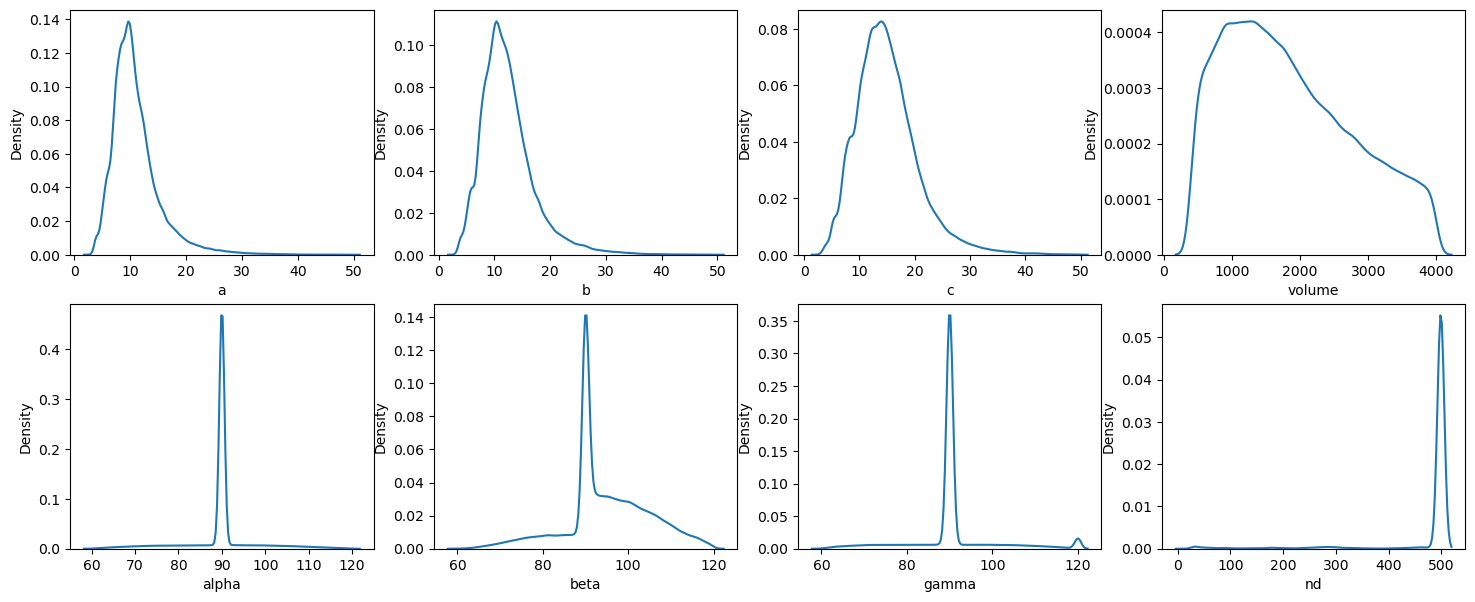

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(18,7))
sns.kdeplot(combined.a, ax=ax[0][0])
sns.kdeplot(combined.b, ax=ax[0][1])
sns.kdeplot(combined.c, ax=ax[0][2])
sns.kdeplot(combined.volume, ax=ax[0][3])
sns.kdeplot(combined.alpha, ax=ax[1][0])
sns.kdeplot(combined.beta, ax=ax[1][1])
sns.kdeplot(combined.gamma, ax=ax[1][2])
sns.kdeplot(combined.nd, ax=ax[1][3])
plt.show()

Things look a bit nicer now! Just out of interest, we'll take a quick look at the distribution of crystal systems and space groups. Other work looking at the CSD and other databases has shown a significant imbalance in the number of crystal structures adopting each crystal system and indeed space group.

<Axes: >

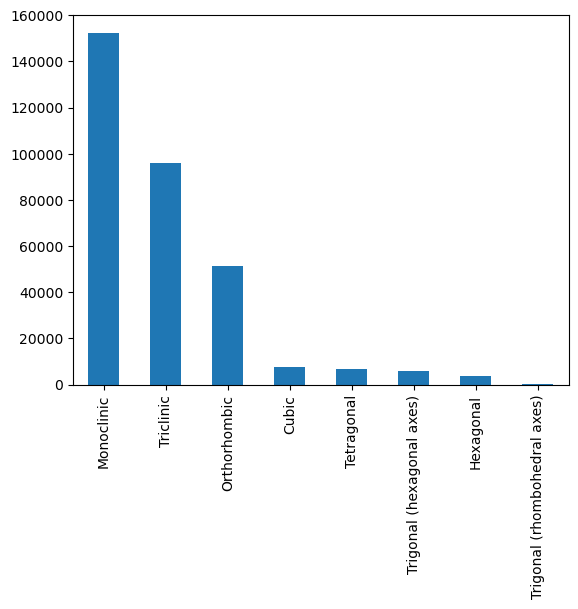

In [8]:
combined.type.value_counts().sort_values().iloc[::-1].head(20).plot.bar()

<Axes: >

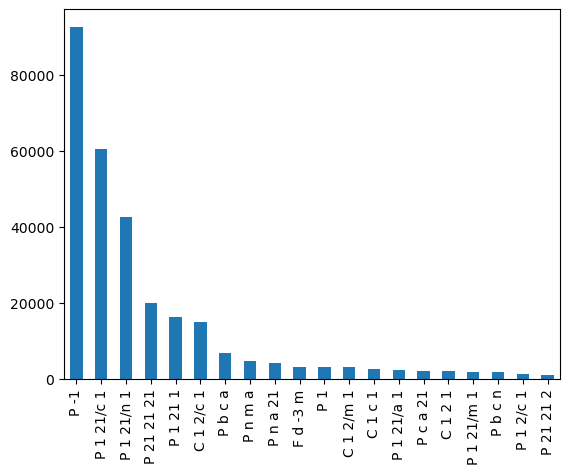

In [9]:
combined.spacegroup_x.value_counts().sort_values().iloc[::-1].head(20).plot.bar()

Unsurprisingly, much like has been observed in both the CSD and ICDD datasets, we again see that some space groups are much more frequently observed than others. In this project, we aren't doing crystal system, space group or extinction symbol classification, but if we come back to that in the future, we would need to keep this fairly severe class imbalance in mind!

We can now turn our attention to the diffraction data - the Miller indices and d-spacings. Some of these entries will have a huge number of peaks, some will have very few. Ideally, we want to ensure that within our chosen data range, we have a reasonable number of peaks. We also want to ensure that there are still a few peaks _outside_ the top end of our data range, meaning that we aren't missing any data inside our range. Each entry has up to 500 d-spacings calculated. With the chosen data range of 4 to 44 degrees, (assU_ming that the radiation source is copper Ka1), we will ensure that none of the peaks are below 4 degrees, and there is at least one peak above 44 degrees.

Our dataframe contains the d-spacings for the observed reflections, so using Bragg's law we can easily convert the angular requirements into d-spacings.

In [10]:
import numpy as np

d_from_tt = lambda x: wavelength/(2*np.sin(np.deg2rad(x)/2))
tt_from_d = lambda x: 2*np.rad2deg(np.arcsin(wavelength/(2*x)))
max_d = d_from_tt(min_data_angle)
min_d = d_from_tt(max_data_angle)
print(f"Minimum angle = {min_data_angle}  : Maximum d-spacing = {max_d:.3f}")
print(f"Maximum angle = {max_data_angle} : Minimum d-spacing = {min_d:.3f}")

Minimum angle = 4  : Maximum d-spacing = 22.071
Maximum angle = 44 : Minimum d-spacing = 2.056


In [12]:
def keepdata(x):
    d = list(filter(None, x.strip().split(",")))
    d = [float(i) for i in d]
    if len(d) == 0:
        return False
    else:
        if d[-1] > min_d:
            return False
        if d[0] > max_d:
            return False
        return True

combined["keepdata"] = combined.dvalue.apply(keepdata)

In [13]:
combined = combined[combined["keepdata"] == True]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd
count,294683.000000,294683.000000,294683.000000,294683.000000,294683.000000,294683.000000,294683.000000,294683.000000
mean,10.882315,12.252111,14.657953,89.811073,95.485959,90.696809,1761.150442,475.402500
std,4.412962,4.931853,5.573568,6.728590,9.625816,8.862066,911.736827,85.123379
min,2.808500,2.825500,2.718100,60.019000,60.130000,60.000000,400.059000,16.000000
25%,8.102900,9.061000,10.947350,90.000000,90.000000,90.000000,1033.393500,498.000000
50%,9.901200,11.254000,13.872700,90.000000,93.575000,90.000000,1587.357000,499.000000
75%,12.471000,14.242100,17.398800,90.000000,101.978000,90.000000,2355.104000,500.000000
max,45.366000,48.809000,49.494500,119.990000,120.000000,120.000000,3999.991000,500.000000


We are down to just shy of 300k samples now.

Lastly, let's ensure that we have sufficient easily detectable peaks within our data range. Do to this, we need to look at the intensities:

In [20]:
combined.intensita

11        1000.000000,293.781700,0.932900,880.099700,350...
12        344.517500,136.663800,113.543400,41.743900,4.9...
13        480.841100,1000.000000,345.837700,13.887000,72...
14        6.550100,7.094000,99.801200,1000.000000,642.20...
17        2.707700,223.647400,1000.000000,119.345700,113...
                                ...                        
458148    191.292600,19.724900,41.216500,169.019100,150....
458151    1000.000000,782.379000,202.061600,29.027900,13...
458155    1000.000000,62.638200,82.940500,3.929300,0.067...
458158    435.793700,1000.000000,156.773800,74.174400,1....
458159    884.735400,207.638600,175.487800,594.721200,42...
Name: intensita, Length: 294683, dtype: object

Intensities are all scaled to a maximum of 1000. We should ensure that in our chosen data range, the intensities that are present are actually strong enough to be observed! Let's say we want the minimum intensity in our data range to be 0.5 % of the maximum intensity. As such, we should have at least 10 intensities in our range with a value greater than 5.

In [21]:
def n_peaks_in_range(dspacing, intensity, min_intensity=5):
    dspacing = list(filter(None, dspacing.strip().split(",")))
    dspacing = np.array([float(i) for i in dspacing])
    intensity = list(filter(None, intensity.strip().split(",")))
    intensity = np.array([float(i) for i in intensity])
    intensity = intensity[dspacing >= min_d]
    return (intensity > min_intensity).sum()

combined["n_detectable_peaks_in_range"] = combined.apply(lambda x: n_peaks_in_range(x.dvalue, x.intensita), axis=1)

In [24]:
combined = combined[combined.n_detectable_peaks_in_range >= min_detectable_peaks_in_range]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd,n_detectable_peaks_in_range
count,288749.000000,288749.000000,288749.000000,288749.000000,288749.000000,288749.000000,288749.000000,288749.000000,288749.000000
mean,10.917842,12.315544,14.766404,89.807191,95.598556,90.697573,1780.395031,484.018237,115.539832
std,4.445510,4.956467,5.569416,6.797322,9.691691,8.930478,909.196809,60.547184,57.885137
min,2.808500,2.825500,2.760000,60.019000,60.130000,60.000000,400.059000,30.000000,10.000000
25%,8.097000,9.133100,11.118900,90.000000,90.000000,90.000000,1054.117000,498.000000,74.000000
50%,9.925400,11.334000,13.981500,90.000000,93.894000,90.000000,1608.456000,499.000000,108.000000
75%,12.546000,14.339000,17.489900,90.000000,102.168000,90.000000,2379.104000,500.000000,150.000000
max,45.366000,48.809000,49.494500,119.990000,120.000000,120.000000,3999.991000,500.000000,386.000000


Now that we've filtered our data to our requirements, the last thing I'm going to do is save the relevant information in numpy arrays which I can then quickly and easily load from disk for future work.

I'll save a few different arrays:
- Unit cells
- Crystal system
- Miller indices
- Peak intensities

As the number of peaks in each pattern is different, the Miller indices and Peak intensity arrays will need padding up to the maximum number, which is 500. First we'll save the unit cells and crystal systems. I'm going to convert the strings for the crystal systems into integers using ```np.unique```, and we can save the keys for use later on.

In [73]:
unit_cell = combined[["a","b","c","alpha","beta","gamma"]].to_numpy()
crystal_systems, crystal_systems_numeric = np.unique(combined.type.to_numpy(), return_inverse=True)
print(crystal_systems)

['Cubic' 'Hexagonal' 'Monoclinic' 'Orthorhombic' 'Tetragonal' 'Triclinic'
 'Trigonal (hexagonal axes)' 'Trigonal (rhombohedral axes)']


Now we'll deal with the Miller indices and intensities. A simple function can be used to convert the strings (as in the database) into arrays and pad them with zeros where needed. We then stack the output into our numpy arrays.

In [43]:
def get_array(x, dtype=np.float32):
    zeros = np.zeros(500, dtype=dtype)
    x = list(filter(None, x.strip().split(",")))
    x = np.array(x, dtype=dtype)
    zeros[:len(x)] = x
    return zeros

h = combined.h.apply(get_array, args=(np.int64,))
k = combined.k.apply(get_array, args=(np.int64,))
l = combined.l.apply(get_array, args=(np.int64,))
intensities = combined.intensita.apply(get_array, args=(np.float32,))

intensities = np.vstack(intensities)
h = np.vstack(h)
k = np.vstack(k)
l = np.vstack(l)
hkl = np.dstack([h,k,l])

Now we can save everything, as well as a file to keep track of our data configuration settings, which we'll save using the ```json``` format.

In [109]:
import json
base_name = f"{min_data_angle}-{max_data_angle}-CuKa1-data_{max_volume}_"
config = {}
config["base_name"] = base_name
config["min_volume"] = min_volume
config["max_volume"] = max_volume
config["max_cell_length"] = max_cell_length
config["min_cell_angle"] = min_cell_angle
config["max_cell_angle"] = max_cell_angle
config["min_data_angle"] = min_data_angle
config["max_data_angle"] = max_data_angle
config["wavelength"] = wavelength
config["min_detectable_peaks_in_range"] = min_detectable_peaks_in_range
config["crystal_systems"] = [x[0]+" = "+str(x[1]) for x in zip(crystal_systems, np.arange(len(crystal_systems)))]

with open(base_name+"data_config.json", "w") as f:
    json.dump(config, f, indent=4)
np.save(base_name+"unit_cell.npy", unit_cell)
np.save(base_name+"crystal_systems_numeric.npy", crystal_systems_numeric)
np.save(base_name+"hkl.npy", hkl)
np.save(base_name+"intensities.npy", intensities)

## Loading data
Now that we have our numpy arrays saved to disk, we need a way to load our diffraction data before feeding it into the functions described below. The framework I'll be using for neural network training is PyTorch, so we need to get our data from disk into pytorch tensors.

Given the size of the dataset we're using (~3.8 GB), we can load it all into memory. If working with limited RAM, however, we'd need a helper function to load from disk into memory. Numpy has a very convenient [memory-mapped load method](https://numpy.org/doc/stable/reference/generated/numpy.load.html) for the .npy files we saved earlier but in this case, it's probably not needed.

In [153]:
with open("4-44-CuKa1-data_4000_data_config.json", "r") as f:
    config = json.load(f)

At this point, it's a good idea for us to split the data into training, validation, and test sets. We'll use a 75/15/10 split. To do that, we'll use a pytorch Dataset, and then apply a random split to get the different sets. To ensure this is consistent between runs on the data, we'll manually set the random seed.

In [264]:
import torch
from torch.utils.data import Dataset

class DiffractionData(Dataset):

    def __init__(self,base_name, root_dir="./"):
        self.crystal_system_numeric = torch.tensor(np.load(root_dir+base_name+"crystal_systems_numeric.npy"))
        self.hkl                    = torch.tensor(np.load(root_dir+base_name+"hkl.npy")).float()
        self.intensities            = torch.tensor(np.load(root_dir+base_name+"intensities.npy")).float()
        self.unit_cell              = torch.tensor(np.load(root_dir+base_name+"unit_cell.npy")).float()

    def __len__(self):
        return len(self.intensities)

    def __getitem__(self, idx):
        return self.crystal_system_numeric[idx], self.hkl[idx], self.intensities[idx], self.unit_cell[idx]



dataset = DiffractionData(config["base_name"])
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.75, 0.15, 0.1], torch.Generator().manual_seed(42))
print(f"Training samples : {len(train_set)}\nValidation samples : {len(val_set)}\nTest samples : {len(test_set)}")

Training samples : 216562
Validation samples : 43313
Test samples : 28874


## Peak positions

Now that we've filtered down the original PowCod database into the entries that meet the (arbitrary) conditions described earlier, it's time to start thinking about how we can use the information to generate synthetic PXRD data.

Rather than using the d-spacings from the database directly, we are going to make use of the unit cells and Miller indices to calculate the d-spacings (and hence angles) for the reflections. This will allow us to add a small amount of noise to the unit cell dimensions, which serves as a form of data augmentation.

The d-spacing of a peak can be calculated using this equation:

$$
NEED TO WRITE THE EQUATION HERE!
$$

where ...

So, we will need a function to convert the unit cell dimensions into the matrix representation of the unit cell, then invert this before using the reciprocal lattice matrix to determine the reciprocal lattice metric tensor. Once we have the reciprocal lattice metric tensor, we can calculate the d-spacings quite easily by multiplying with the Miller index array(s).

To simulate the effect of temperature changes, we'll add a small amount of Gaussian noise to the unit cell dimensions. We will have to consider the crystal system symmetry here in order to ensure that, for example a cubic unit cell, the perturbation to lengths $b$ and $c$ is equal to the pertubation to $a$.

I'll be fairly conservative about how much the dimensions get perturbed, and set the standard deviation of the random noise to 0.05, meaning that the majority of perturbed unit cells should have edges with lengths +/- 0.15 angstroms from the database values, and angles +/- 0.15 degrees (assU_ming they are allowed to very by symmetry). This seems reasonable, and should allow us to assume that the fractional coordinates within the unit cells are unaffected, so we don't need to worry about the effect on the relative intensities.

In [175]:
def get_unit_cell_perturbation(crystal_systems, dtype=torch.float32, stddev=0.05):
    batchsize = crystal_systems.shape[0]
    device = crystal_systems.device
    lengths, angles = torch.randn((2, batchsize, 3), device=device, dtype=dtype) * stddev
    cubic = crystal_systems == 0
    hexagonal = crystal_systems == 1
    monoclinic = crystal_systems == 2
    #orthorhombic = crystal_systems == 3 # Don't need to query data for this
    tetragonal = crystal_systems == 4
    triclinic = crystal_systems == 5
    trigonal_h = crystal_systems == 6
    trigonal_r = crystal_systems == 7

    # Cubic, tetragonal, rhombohedral and hexagonal - a and b must be the same
    lengths[:,1] = torch.where(cubic | hexagonal | tetragonal | trigonal_h | trigonal_r,
                            lengths[:,0], lengths[:,1])
    # Cubic and rhombohedral cells - a, b and c must be the same
    lengths[:,2] = torch.where(cubic | trigonal_r, lengths[:,0], lengths[:,2])
    # Rhombohedral and triclinic cells - could change their alpha values
    angles[:,0] = torch.where((trigonal_r | triclinic), angles[:,0], 0.)
    # Triclinic or monoclinic cells could change beta values
    angles[:,1] = torch.where((triclinic | monoclinic), angles[:,1], 0.)
    # Triclinc cells could change gamma
    angles[:,2] = torch.where(triclinic, angles[:,2], 0.)
    # Rhombohedral cells - need to ensure all angles are the same
    angles[:,1] = torch.where(trigonal_r, angles[:,0], angles[:,1])
    angles[:,2] = torch.where(trigonal_r, angles[:,0], angles[:,2])

    return lengths, angles

Let's check it does what it's meant to!

What we're expecting is that for the unit cell lengths, the perturbation should be the same for each of the edges for cubic and rhombohedral cells, and the perturbation for $a$ and $b$ should be the same for hexagonal and tetragonal cells.

With regards to angles, where the original unit cell is an angle of 90 or 120 degrees, the perturbation should be zero. So we should see a change in the beta value for monoclinic cells, a change for all values of the triclinic unit cells and the same change for each of the angles for rhombohedral cells.

In [186]:
for c in config["crystal_systems"]:
    name, number = c.split(" = ")
    lengths, angles = get_unit_cell_perturbation(torch.tensor([int(number)]))
    print(name, "Length perturbation:", lengths)
    print(name, "Angle perturbation", angles,"\n")

Cubic Length perturbation: tensor([[0.0211, 0.0211, 0.0211]])
Cubic Angle perturbation tensor([[0., 0., 0.]]) 

Hexagonal Length perturbation: tensor([[-0.0229, -0.0229,  0.0531]])
Hexagonal Angle perturbation tensor([[0., 0., 0.]]) 

Monoclinic Length perturbation: tensor([[-0.1008,  0.0537, -0.0333]])
Monoclinic Angle perturbation tensor([[0.0000, 0.0365, 0.0000]]) 

Orthorhombic Length perturbation: tensor([[ 0.0158,  0.0068, -0.0314]])
Orthorhombic Angle perturbation tensor([[0., 0., 0.]]) 

Tetragonal Length perturbation: tensor([[0.0366, 0.0366, 0.0669]])
Tetragonal Angle perturbation tensor([[0., 0., 0.]]) 

Triclinic Length perturbation: tensor([[ 0.0249, -0.0221,  0.0535]])
Triclinic Angle perturbation tensor([[-0.0636, -0.0724, -0.1099]]) 

Trigonal (hexagonal axes) Length perturbation: tensor([[0.0048, 0.0048, 0.0696]])
Trigonal (hexagonal axes) Angle perturbation tensor([[0., 0., 0.]]) 

Trigonal (rhombohedral axes) Length perturbation: tensor([[-0.0257, -0.0257, -0.0257]])

Looks good to me. We now need to start writing functions to generate our lattice matrix, reciprocal lattice matrix and reciprocal lattice metric tensor. We can then use these in conjunction with the Miller indices to determine the reflection d-spacings.

One other thing we should during this process is to check that the perturbed unit cells actually give valid unit cells. We can do that by calculating the volume of the unit cells - if the value is > 0 then the unit cell is valid, otherwise, the set of lengths and angles do not construct a valid parallelipiped.

In [199]:
def get_lattice_matrix(unit_cell_dimensions):
    pi_over_180=0.017453292519943295
    a, b, c = unit_cell_dimensions[:,:3].T
    cosal, cosbe, cosga = torch.cos(unit_cell_dimensions[:,3:]*pi_over_180).T
    sinal, sinbe = torch.sin(unit_cell_dimensions[:,3:-1]*pi_over_180).T
    # Sometimes rounding errors cause |values| slightly > 1.
    val = torch.clamp((cosal * cosbe - cosga) / (sinal * sinbe), min=-1, max=1)

    gamma_star = torch.arccos(val)
    zeros = torch.zeros_like(c)
    v_a = torch.stack([a * sinbe, zeros, a*cosbe]).T
    v_b = torch.stack([-b * sinal * torch.cos(gamma_star),
                    b*sinal * torch.sin(gamma_star),
                    b*cosal]).T
    v_c = torch.stack([zeros, zeros, c]).T

    matrix = torch.stack([v_a,v_b,v_c], dim=2)

    # Unit cells are valid if cell volume > 0
    # The cell volume is |det(M)|, but don't need the absolute value here
    volume = torch.linalg.det(matrix)
    valid = volume != 0

    return matrix, valid

Again, let's quickly check that this works as expected. I'll give it a simple cubic unit cell, and an invalid unit cell.

In [265]:
cubic_cell = torch.tensor([5.0,5.0,5.0,90.0,90.0,90.0]).unsqueeze(0)
invalid_cell = torch.tensor([5.0,6.0,7.0,120.0,120.0,120.0]).unsqueeze(0)
print("Cubic cell valid -",get_lattice_matrix(cubic_cell)[1].item())
print("Invalid cell valid -", get_lattice_matrix(invalid_cell)[1].item())

Cubic cell valid - True
Invalid cell valid - False


I'll add the other functions, then a little wrapper to combine them, which will allow us to feed in unit cells and Miller indices, and get back peak positions.

In [266]:
def get_recip_lattice_metric_tensor(recip_lattice_matrix):
    return recip_lattice_matrix @ recip_lattice_matrix.permute(0,2,1)

def get_d_spacing(recip_latt_metric_tensor,hkl):
    one_over_d_squared = torch.einsum("bij,bji->bi",hkl,torch.einsum(
                                "bij,bkj->bik",recip_latt_metric_tensor,hkl))
    d = 1/torch.sqrt(one_over_d_squared)
    return d

def d_to_tt(d,wavelength):
    two_times_180_over_pi = 114.59155902616465
    tt = two_times_180_over_pi*torch.arcsin(wavelength/(2*d))
    return tt

def get_peak_positions(unit_cells, hkl, wavelength=1.54056):
    lattice_matrix, valid = get_lattice_matrix(unit_cells)
    unit_cells = unit_cells[valid]
    hkl = hkl[valid]
    reciprocal_lattice_matrix = torch.linalg.inv(lattice_matrix)
    reciprocal_lattice_metric_tensor = get_recip_lattice_metric_tensor(reciprocal_lattice_matrix)
    d_spacing = get_d_spacing(reciprocal_lattice_metric_tensor, hkl)
    twotheta = d_to_tt(d_spacing, wavelength)
    return twotheta

I'll test that using some diffraction data for a [Carbamazepine:Indomethacin cocrystal](https://www.mdpi.com/2073-4352/10/1/42) I published a while ago. The first 3 peaks have the following Miller indices and positions:

| h | k | l | $2\theta$ |
|---|---|---|-----------|
| 1 | 1 | 0 | 5.322  |
| 2 | 0 | 0 | 7.496  |
| 0 | 2 | 0 | 7.562  |

And the unit cell is:

23.573194, 23.363375, 5.125218, 90.000, 88.77132, 90.000

In [267]:
coXtal_unit_cell = torch.tensor([23.573194, 23.363375, 5.125218, 90.000, 88.77132, 90.000])
coXtal_hkl = torch.tensor([[1,1,0],[2,0,0],[0,2,0]]).float()

coXtal_twotheta = get_peak_positions(coXtal_unit_cell.reshape(1,6), coXtal_hkl.reshape(1,3,3))
print("Calculated peak positions:")
for i, ht in enumerate(zip(coXtal_hkl, coXtal_twotheta.squeeze())):
    print(ht[0].int().tolist(), f"{ht[1].item():.3f}")

Calculated peak positions:
[1, 1, 0] 5.322
[2, 0, 0] 7.496
[0, 2, 0] 7.562


That looks like it's working nicely!

## Peak intensities

The main contribution to the intensity of a diffraction peak is the position of the atoms within the unit cell. In terms of the PowCod database, this has already been calculated, and can be read in from the intensities array we saved earlier.

However, there are experimental/physical effects that can modulate these intensities. Most import is the effect of preferred orientation. There are several ways to model this, I'm choosing to implement the [March-Dollase](https://scripts.iucr.org/cgi-bin/paper?a26366) method as I already have some code written to do this in GALLOP. This code is actually based on code from GSAS-II; see the ```GetPrefOri``` function in the file found [here](https://subversion.xray.aps.anl.gov/pyGSAS/trunk/GSASIIstrMath.py). I updated it to use pytorch, and work over a batch of multiple PXRD patterns.

Again, this is being implemented as a form of data augmentation, allowing our existing data to generate multiple different, but plausible, diffraction patterns.


Future work could extend this to use the more sophisticated spherical harmonic approach described [here](http://scripts.iucr.org/cgi-bin/paper?S0021889897005918).

In [253]:
def get_MD_PO_components(hkl, reciprocal_lattice_matrix, factor_stddev=0.1):
    batchsize = hkl.shape[0]
    device = hkl.device
    dtype = hkl.dtype
    # Randomly assign the PO axis to be either [1,0,0], [0,1,0] or [0,0,1]
    PO_axis = torch.zeros((batchsize, 3), device=device, dtype=dtype)
    PO_axis_select = torch.randint(0,3,(batchsize,),device=device)
    PO_axis[torch.arange(batchsize, device=device),PO_axis_select] = 1.0

    u = hkl / torch.sqrt(torch.einsum("bkj,bkj->bk", hkl,
                        torch.einsum("bij,bkj->bki",
                        reciprocal_lattice_matrix,hkl))).unsqueeze(2)

    cosP = torch.einsum("bij,bj->bi", u, torch.einsum("bij,bj->bi",
                    reciprocal_lattice_matrix, PO_axis))
    one_minus_cosPsqd = 1.0-cosP**2
    one_minus_cosPsqd[one_minus_cosPsqd < 0.] *= 0.
    sinP = torch.sqrt(one_minus_cosPsqd)

    # MD factor = 1 means no PO. Use a normal distribution with stddev given in argument
    # centred at 1.
    factor = (torch.randn((batchsize,1),device=device,dtype=dtype) * factor_stddev) + 1.

    return cosP, sinP, factor, PO_axis

def apply_MD_PO_correction(intensities, cosP, sinP, factor):
    A_all = (1.0/torch.sqrt(((factor)*cosP)**2+sinP**2/(factor)))**3
    return intensities * A_all

## Peak shapes
Now that we can calculate where the peaks will be, and modulate the intensity of the peaks if we want to, we now need to think about the shape of the peaks.

There are several possible peak shapes that we could go for, however, in order to try to get relatively realistic results, I decided to implement full Voigt functions, and also include the [Finger, Cox and Jephcoat](https://scripts.iucr.org/cgi-bin/paper?hn0025) correction for peak asymmetry.

We need to calculate a gaussian peak, a lorentzian peak and the FCJ profile, then convolve them together. Using the convolution theorem, we can do this by first Fourier transforming them, calculating their pointwise product in Fourier space, then inverse Fourier transforming the resultant product and taking the real components.

I also decided to implement peak broadening as a function of the peak position, using the well established U,V,W,X,Y,Z parameters described [here](https://journals.iucr.org/j/issues/2021/06/00/gj5272/) and elsewhere.

In [ ]:
def gaussian(x, mu, sig):
    root_two_pi = 2.5066282746310002
    peak = (1/(sig*root_two_pi))*torch.exp(-0.5*(x-mu)**2/sig**2)
    return peak/peak.max(dim=-1).values.unsqueeze(2)

def lorentzian(x, loc, gam):
    one_over_pi = 0.3183098861837907
    peak = one_over_pi*(gam/((x - loc)**2+gam**2))
    return peak/peak.max(dim=-1).values.unsqueeze(2)

def fcj(data,twotheta,shl):
    step = data[1] - data[0]
    pi_over_180 = 0.017453292519943295
    T = step*data+twotheta
    abs_cos_T = torch.abs(torch.cos(T*pi_over_180))
    abs_cos_T_sqd = abs_cos_T**2
    cos_sqd_twotheta = torch.cos(twotheta*pi_over_180)**2
    cos_sqd_twotheta = torch.where(abs_cos_T_sqd>cos_sqd_twotheta,
                                    cos_sqd_twotheta,abs_cos_T_sqd)
    fcj_profile = torch.where(abs_cos_T_sqd>cos_sqd_twotheta,
                    (torch.sqrt(cos_sqd_twotheta/(abs_cos_T_sqd-cos_sqd_twotheta+1e-9))
                    -1./shl)/abs_cos_T,0.0)
    fcj_profile = torch.where(fcj_profile > 0.,fcj_profile,0.)
    return fcj_profile

def get_UVWZ(batchsize, device, dtype, U_min=0.0001, U_max=0.0004,
            V_min=0.0001, V_max=0.0004, W_min=0.0001, W_max=0.0004,
            Z_min=0.0001, Z_max=0.0004):
    U = ((torch.rand(batchsize, device=device, dtype=dtype) * (U_max-U_min))
            + U_min).unsqueeze(1)

    V = ((torch.rand(batchsize, device=device, dtype=dtype) * (V_max-V_min))
            + V_min).unsqueeze(1)

    W = ((torch.rand(batchsize, device=device, dtype=dtype) * (W_max-W_min))
            + W_min).unsqueeze(1)

    Z = ((torch.rand(batchsize, device=device, dtype=dtype) * (Z_max-Z_min))
            + Z_min).unsqueeze(1)

    return U, V, W, Z

def get_XY(batchsize, device, dtype, X_min=0.001, X_max=0.035,
            Y_min=0.001,Y_max=0.035):

    X = ((torch.rand(batchsize, device=device, dtype=dtype) * (X_max-X_min))
            + X_min).unsqueeze(1)

    Y = ((torch.rand(batchsize, device=device, dtype=dtype) * (Y_max-Y_min))
            + Y_min).unsqueeze(1)

    return X, Y

def get_hwhm_G(tan_twotheta, cos_twotheta, U, V, W, Z):
    tan_twotheta = tan_twotheta.squeeze()
    cos_twotheta = cos_twotheta.squeeze()
    return torch.sqrt((U * tan_twotheta**2) + (V * tan_twotheta)
                        + W + (Z/(cos_twotheta**2))).unsqueeze(2)

def get_hwhm_L(tan_twotheta, cos_twotheta, X, Y):
    tan_twotheta = tan_twotheta.squeeze()
    cos_twotheta = cos_twotheta.squeeze()
    return ((X * tan_twotheta) + (Y/cos_twotheta)).unsqueeze(2)

def get_shl(batchsize, device, dtype, shlmax=0.5):
    shl = torch.rand((batchsize, 1, 1), device=device, dtype=dtype) * shlmax
    return shl

def get_zero_point_error(batchsize, device, dtype, zpemin=0.03, zpemax=0.03):
    zero_point_error = (torch.rand((batchsize,1,1), device=device, dtype=dtype)
                        * (zpemax - zpemin)) + zpemin
    return zero_point_error

## Misc

## Background
I used 20th-degree chebyshev polynomials to model the background. These were generated with completely random components without really trying to make them look "realistic", and hence some of the background shapes look quite funky! However, in and amongst the unusual backgrounds, the model is learning to ignore the peaks and generate smooth functions that can model the background regardless of how it looks.

In [1]:
#| code-fold: true
import matplotlib.pyplot as plt

def get_background(batchsize, chebyshev_basis, device, dtype, bg_prm_std_max=0.025, bg_prm_std_min=0.0):
    params = ((torch.rand((batchsize,1,1), device=device, dtype=dtype) * (bg_prm_std_max - bg_prm_std_min)) + bg_prm_std_min)*torch.randn((batchsize, chebyshev_basis.shape[0], 1), device=device, dtype=dtype)
    bg = (params * chebyshev_basis).sum(dim=1)
    return bg

ttmin = 4
ttmax = 44
datadim = 2048
device = torch.device("cpu")
dtype = torch.float32

data = torch.linspace(ttmin, ttmax, datadim, device=device, dtype=dtype)

# Background using Chebyshev polynomials
ttstar = (2*(data - ttmin)/(ttmax - ttmin)) - 1
degree = 20
n = torch.arange(degree,device=device,dtype=dtype).unsqueeze(1)
chebyshev_basis = torch.cos(n*torch.arccos(ttstar))

batchsize = 4
bgs = get_background(batchsize, chebyshev_basis, device, dtype)
bgs -= bgs.min(dim=-1).values.unsqueeze(1)

fig, ax = plt.subplots(1,1,figsize=(10,6))
for bg in bgs:
    ax.plot(data, bg)
ax.set_xlabel("$2\\theta$")
ax.set_title("Example randomly generated backgrounds")
plt.show()

NameError: name 'torch' is not defined